<img src="../logo.png" alt="Drawing" style="width: 200px;"/>

## Polynomial Regression

Polynomial Regression is the same as Linear Regression but we're adding polynomial features to the dataset. For instance if we have two features $x_1$, and $x_2$. We'll add $x_1^2$, $x_2^2$, $x_1x_2$, $x_1^3$ and so on. Adding these features will give us a non-linear fit, i.e. a boundary that's not simple plain line. 

In [13]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize

df = pd.read_csv('machine_learning_andrewng/ex2data2.csv', header=None)
df.rename(columns={0: 'chip1', 1: 'chip2', 2: 'y'}, inplace=True)
df.head()

,chip1,chip2,y
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


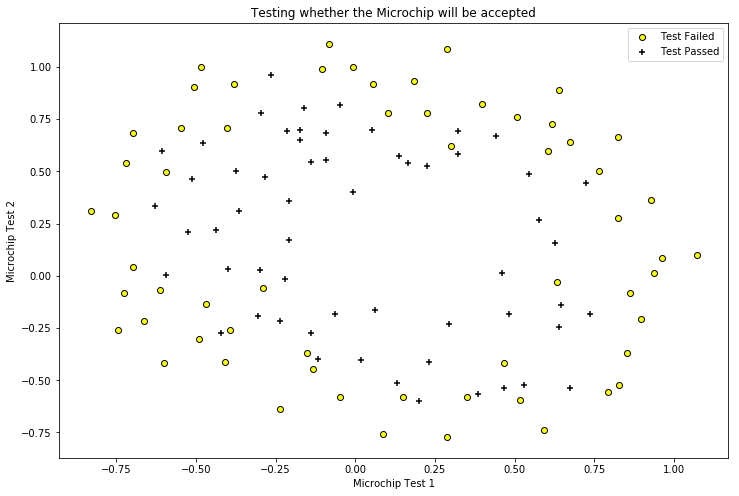

In [14]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(df[df['y'] == 0]['chip1'], df[df['y'] == 0]['chip2'],
            label='Test Failed', color='yellow', edgecolor='black')
plt.scatter(df[df['y'] == 1]['chip1'], df[df['y'] == 1]['chip2'],
            label='Test Passed', marker='+', color='black')
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(loc='upper right')
plt.title('Testing whether the Microchip will be accepted')
plt.show()

In [15]:
class LogisticRegression(object):
    def __init__(self, X, y, alpha=0.001, n_iterations=5000,
                 lambda_param=0, verbose=True):
        self.y = self._handle_data_type(y)
        self.X = self._handle_data_type(X)
        self.X = self._hstack_one(X)
        self.thetas = np.zeros((self.X.shape[1]))
        self.n_rows = self.X.shape[0]
        self.n_features = self.thetas.shape[0]
        self.alpha = alpha
        self.n_iterations = n_iterations
        self.lambda_param = lambda_param
        if verbose:
            print("Number of features: {0}".format(self.n_features - 1))
            print("Cost before fitting: {0:.4f}".format(self.cost()))
    
    @staticmethod
    def _handle_data_type(new_X):
        return new_X
    
    @staticmethod
    def _hstack_one(input_matrix):
        if len(input_matrix.shape) == 1:
            return np.hstack((np.array([1]), input_matrix))
        else:
            return np.hstack((np.ones((input_matrix.shape[0], 1)), input_matrix))
        
    @staticmethod
    def sigmoid(X):
        return 1/(1 + np.exp(-X))
        
    def cost(self, thetas=None):
        if thetas is None:
            thetas = self.thetas
        dot_prod = self.X.dot(thetas)
        dot_prod_pos = dot_prod[self.y == 1]
        dot_prod_neg = dot_prod[self.y == 0]
        # TODO: Add limit parameter to prevent
        # log underflow
        # https://stackoverflow.com/a/47244817/1878563
        cost = -(1/self.n_rows) * (np.sum(np.log(self.sigmoid(dot_prod_pos))) \
                                + np.sum(np.log(1 - self.sigmoid(dot_prod_neg)))) \
                         + (self.lambda_param/(2*self.n_rows)) \
                     * np.sum(self.thetas[1:]**2)
        return cost
    
    def predict(self, new_X, threshold=0.5):
        new_X = self._handle_data_type(new_X)
        assert new_X.shape[0] != self.X.shape[1], \
            "Number of features don't match. {0} != {1}".format(new_X.shape[1],
                                                                self.X.shape[1])
        new_X = self._hstack_one(new_X)
        h = new_X.dot(self.thetas)
        results = self.sigmoid(h) >= threshold
        return results
    
    def batch_gradient(self, thetas=None):
        if thetas is None:
            thetas = self.thetas
        h = self.sigmoid(self.X.dot(thetas)) - self.y
        h = np.multiply(self.X, h.reshape(-1, 1))
        h = np.sum(h, axis=0)
        reg = thetas * self.lambda_param
        reg[0] = 0 # don't regularize theta_0
        h += reg
        return h
    
    def batch_gradient_descent(self, ):
        alpha_by_m = self.alpha/self.n_rows
        for i in range(self.n_iterations):
            self.thetas = self.thetas - (alpha_by_m * self.batch_gradient())
            cost = self.cost()
            print("\rIteration: {0} Loss: {1:.5f}".format(i + 1, cost)  + "")
        print
    
    def scipy_optimize(self, verbose=True):
        result = minimize(self.cost, self.thetas, jac=self.batch_gradient, 
                          options={'maxiter': self.n_iterations})
        if verbose:
            print(result)
        self.thetas = result.x

### Simple Logistic Regression

In [16]:
simple_lr = LogisticRegression(df[['chip1', 'chip2']].values, df['y'].values, n_iterations=20000)
simple_lr.scipy_optimize()

Number of features: 2
Cost before fitting: 0.6931
      fun: 0.69024112201698
 hess_inv: array([[ 0.03954989, -0.0116338 , -0.02684334],
       [-0.0116338 ,  0.14515993,  0.02196225],
       [-0.02684334,  0.02196225,  0.14320469]])
      jac: array([-8.04472319e-06, -5.74084101e-07, -1.09410551e-06])
  message: 'Optimization terminated successfully.'
     nfev: 165
      nit: 48
     njev: 165
   status: 0
  success: True
        x: array([-0.01418441, -0.30352114, -0.01813174])


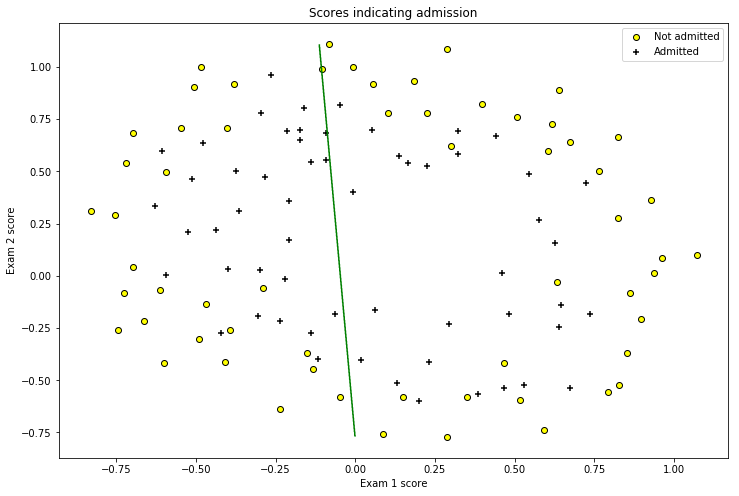

In [17]:
# Plotting the prediction line
def plot(col1, col2, clf):
    min_ex1 = df[col1].min()
    max_ex1 = df[col1].max()

    min_ex2 = df[col2].min()
    max_ex2 = df[col2].max()

    arange_step = 0.001

    xx, yy = np.meshgrid(np.arange(min_ex1, max_ex1, arange_step), 
                         np.arange(min_ex2, max_ex2, arange_step))
    preds = np.c_[xx.ravel(), yy.ravel()]
    preds = clf.predict(preds)
    preds = preds.reshape(xx.shape)
    fig = plt.figure(figsize=(12, 8))
    plt.scatter(df[df['y'] == 0][col1], df[df['y'] == 0][col2],
                label='Not admitted', color='yellow', edgecolor='black')
    plt.scatter(df[df['y'] == 1][col1], df[df['y'] == 1][col2],
                label='Admitted', marker='+', color='black')
    plt.contour(xx, yy, preds, [0.5], colors='green')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend(loc='upper right')
    plt.title('Scores indicating admission')
    plt.show()
    
plot("chip1", "chip2", simple_lr)

In [18]:
from sklearn.preprocessing import PolynomialFeatures
X = df[['chip1', 'chip2']].values
kernel = PolynomialFeatures(6)
X = kernel.fit_transform(X)
X = X[:, 1:]
y = df['y'].values
print(X.shape)
poly_lr = LogisticRegression(X, y, lambda_param=100, n_iterations=20000)
poly_lr.scipy_optimize()

(118, 27)
Number of features: 27
Cost before fitting: 0.6931
      fun: 0.6802434024711351
 hess_inv: array([[ 4.23984171e-02, -1.71383426e-02, -2.38290924e-04,
         2.02861892e-02, -6.47610740e-03,  1.91629457e-02,
        -9.82653723e-03,  1.15108124e-03, -6.28776882e-04,
        -9.07568393e-03,  2.63613455e-03, -2.90371388e-03,
         3.82792244e-03, -2.61956629e-03, -5.14944483e-03,
        -8.39710563e-03,  3.99420393e-05, -5.48575475e-04,
        -5.21552667e-06, -3.66343522e-04, -1.59309471e-02,
        -3.17290267e-03, -1.79242705e-03,  1.19858370e-03,
        -9.13433031e-04,  4.91298557e-04, -1.54604264e-03,
        -1.54675705e-02],
       [-1.71383426e-02,  5.12692985e-01, -1.18408858e-01,
        -1.82832779e-01,  1.28144257e-01, -1.17568724e-01,
        -2.81545853e-01,  5.64146455e-02, -4.17312757e-02,
         5.04789812e-02, -5.61753462e-02,  1.09395661e-02,
         2.47817442e-02,  2.63464881e-02,  9.62040081e-02,
        -1.67300467e-01,  2.86379290e-02, -2.5

/home/xenonstack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp


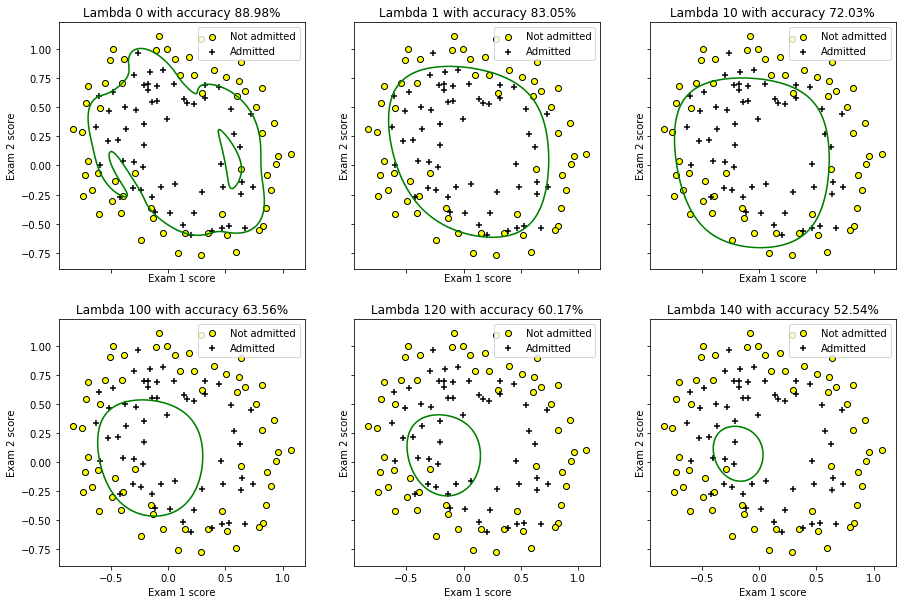

In [19]:
# visualizing the effect
X = df[['chip1', 'chip2']].values
kernel = PolynomialFeatures(6)
X = kernel.fit_transform(X)
X = X[:, 1:]
y = df['y'].values

col1 = "chip1"
col2 = "chip2"
min_ex1 = df[col1].min()
max_ex1 = df[col1].max()
min_ex2 = df[col2].min()
max_ex2 = df[col2].max()
arange_step = 0.001
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 10))
xx, yy = np.meshgrid(np.arange(min_ex1, max_ex1, arange_step), 
                        np.arange(min_ex2, max_ex2, arange_step))

lambdas = [0, 1, 10, 100, 120, 140]
for index, lambda_param in enumerate(lambdas):
    poly_lr = LogisticRegression(X, y, lambda_param=lambda_param, verbose=False)
    poly_lr.scipy_optimize(verbose=False)
    preds = np.c_[xx.ravel(), yy.ravel()]
    accuracy = 100*(np.sum(poly_lr.predict(X) == y)/y.size)
    preds = kernel.transform(preds)
    preds = preds[:, 1:]
    preds = poly_lr.predict(preds)
    preds = preds.reshape(xx.shape)
    fl_axes = axes.flatten()[index]
    fl_axes.scatter(df[df['y'] == 0][col1], df[df['y'] == 0][col2],
                    label='Not admitted', color='yellow', edgecolor='black')
    fl_axes.scatter(df[df['y'] == 1][col1], df[df['y'] == 1][col2],
                    label='Admitted', marker='+', color='black')
    fl_axes.contour(xx, yy, preds, [0.5], colors='green')
    fl_axes.set_xlabel('Exam 1 score')
    fl_axes.set_ylabel('Exam 2 score')
    fl_axes.legend(loc='upper right')
    fl_axes.set_title("Lambda {0} with accuracy {1:.2f}%".format(lambda_param, accuracy))
plt.show()

<p>&copy; 2018 Stacklabs<p>
